In [1]:
import pandas as pd 
import os 
import time
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import re
import requests

In this first function list_of_towns() we will be introducing our headless webdriver for Chrome. What that means is in the background, without actually opening up a window for you to see, Selenium will go to the Virginia Municode page https://library.municode.com/VA. From there, it will wait 5 seconds for the page to load. This is an essential step (and why Selenium is such a great webscraping tool!) for sites that generate content via javascript instead of a traditional html/css webpage. Once the 5 seconds has passed, the Selenium scraper looks at the xpath we have designated. An xpath is a precise location on a webpage, like a specific button or div. This location is extracted and saved down into a variable 'data' so that the element we found at the xpath destination can be used. In this first function, we are interested in extracting the links to all of the various towns and counties within Virginia that are listed on Municode. The webpage looks like this:
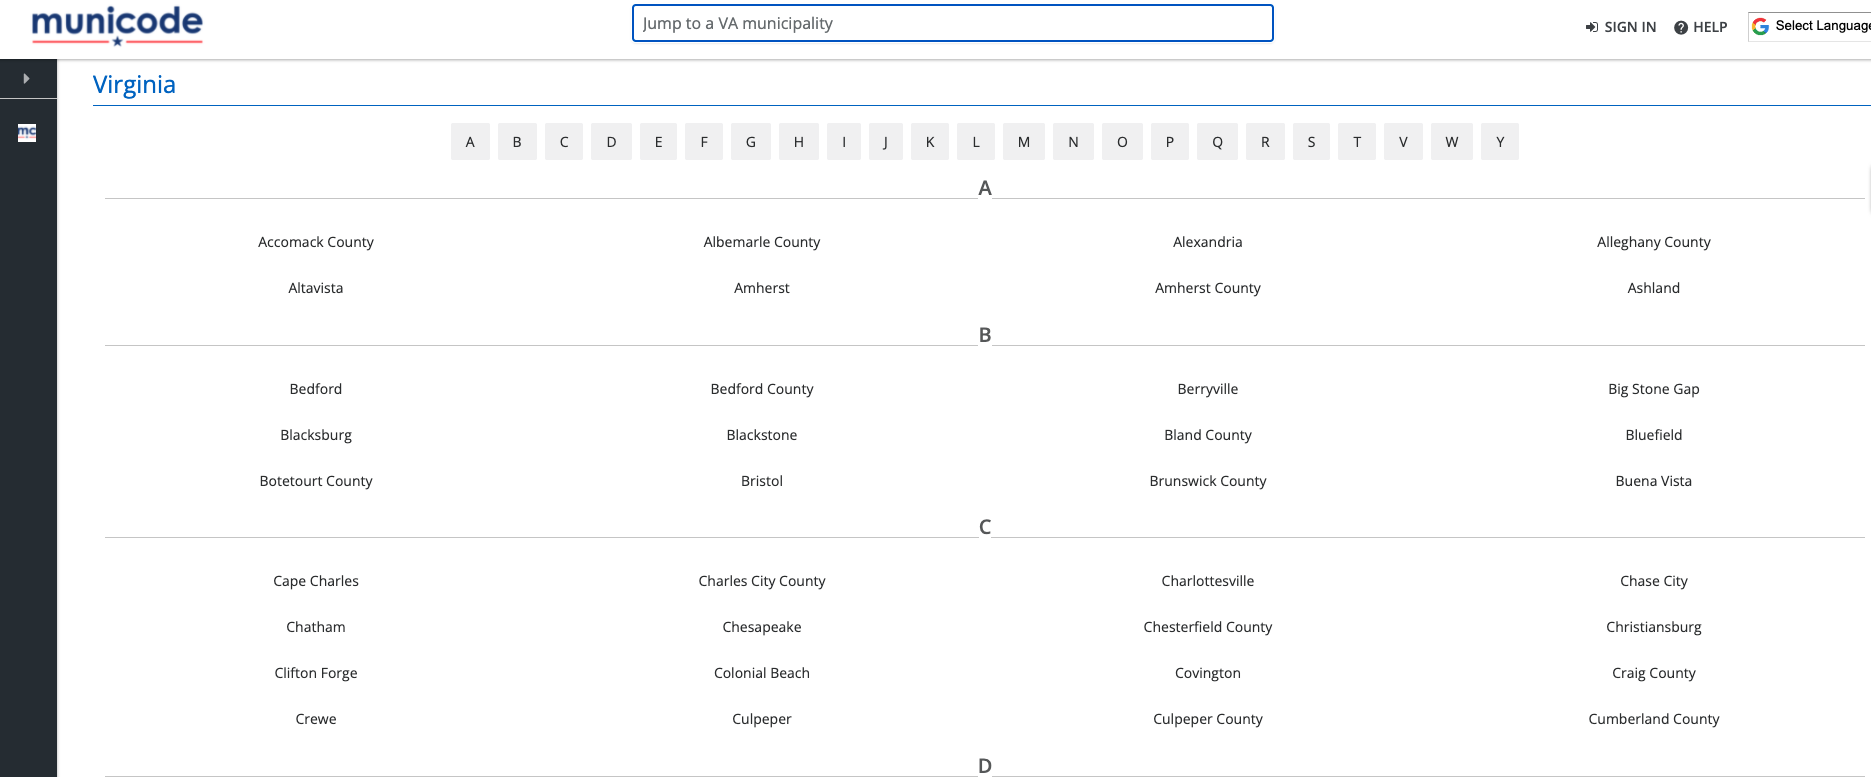
Each of the towns and counties listed on this page are buttons that link to their respective pages. What this function does is take all of those links and return a single column dataframe. Finally, we split every value in that column to extract the town/county ID. For example, the link for Accomack County is https://library.municode.com/VA/accomack_county, which we then extract "accomack_county" from and save in a second column in the same dataframe.

In [11]:
def list_of_towns():
    # silence
    options = webdriver.ChromeOptions()
    options.add_argument("headless")

    driver = webdriver.Chrome('/Users/holdenbruce/Downloads/chromedriver3', options=options)

    # set implicit wait time so that apis/javascript load before we scrape 
    driver.implicitly_wait(5) # seconds

    # url of the county
    url = f"https://library.municode.com/VA"
    # headers to let them know who i am
    headers = {'user-agent': 'class project (hab6xf@virginia.edu)'}
    # xpath of the table in the webpage created by javascript 
    xpathHOME = "/html/body/div[1]/div[2]/ui-view/div[2]/section/div/div"

    driver.get(url)

    # use xpath to get to the table
    data = driver.find_elements_by_xpath(xpathHOME)
    # links = driver.find_elements_by_tag_name("a")
    
    # add a delay of 3 seconds in the function
    time.sleep(2)
    
    # use outerHTML to maintain the html/css/javasript code pulled from the webpage 
    html = data[0].get_attribute("outerHTML")

    r1 = re.findall(r"https://library.municode.com/VA/[\w\.-]+",html)

    # convert to dataframe and drop duplicates
    towns_list = pd.DataFrame(r1)
    towns_list = towns_list.drop_duplicates().reset_index(drop=True)
    
    town_urls = list_of_towns()
    town_urls = town_urls.rename(columns={0:"urls"})

    splits = town_urls['urls'].str.split("/")#[-1]
    for x in range(len(splits)):
        town_urls.loc[x,'county'] = splits[x][-1]

    return towns_list

In [12]:
town_urls

,urls,county
0,https://library.municode.com/VA/accomack_county,accomack_county
1,https://library.municode.com/VA/albemarle_county,albemarle_county
2,https://library.municode.com/VA/alexandria,alexandria
3,https://library.municode.com/VA/alleghany_county,alleghany_county
4,https://library.municode.com/VA/altavista,altavista
...,...,...
145,https://library.municode.com/VA/windsor,windsor
146,https://library.municode.com/VA/wise_county,wise_county
147,https://library.municode.com/VA/woodstock,woodstock
148,https://library.municode.com/VA/wytheville,wytheville


In the second function, identify_comparison_table_URL_part1(), we pass in a url like https://library.municode.com/VA/accomack_county. These individual town/county pages look like this:

   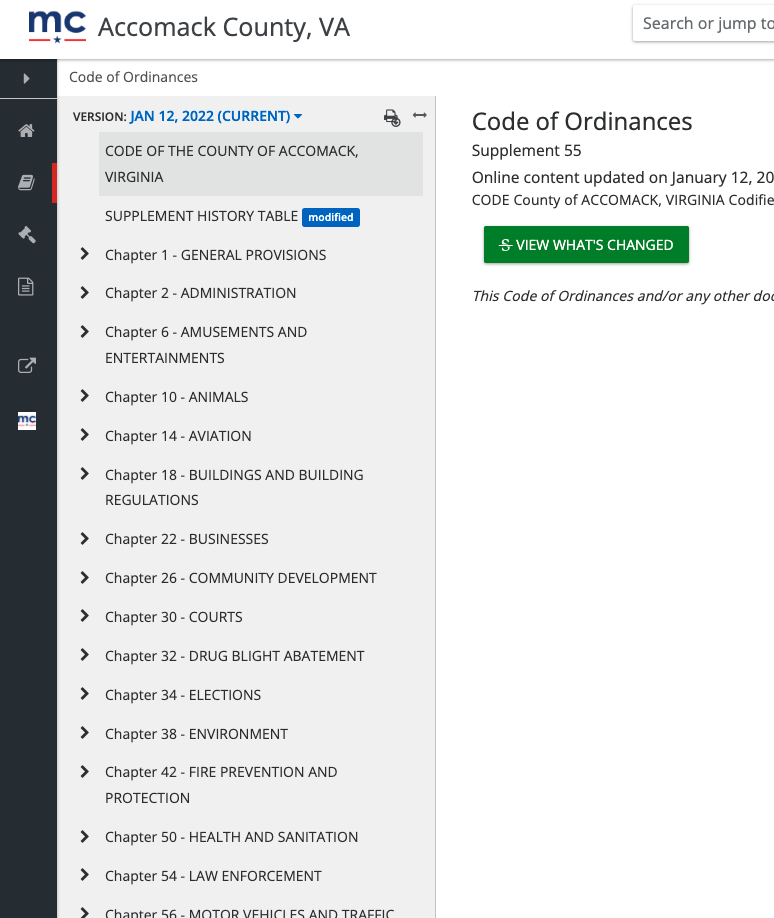

What we're interested in here is the menu bar on the left hand side of the page. You will see in the code below a series of try/except statements that look for different id tags. These tags represent "State Law Reference Tables" and are referred to as STLARETA, STRETA, COOR_STRETA, and STATE_LAW_REFERENCE_TABLE. There is much information present in these town/county pages but this is the only thing we care about for this project, since it contains a table that compares the law codes for the State of Virginia to the law codes for that specific town/county. This is useful for CodeForCharlottesville and the LAJC Virginia Criminal Expungement initiative because it allows us to create a mapping of all the various law codes for the towns and counties across Virginia to the law codes for the State. Why is this significant? The new laws that have relaxed Virginia's draconian criminal expungmenet policies necessitate this mapping to be known in order for offenders to have their crimes expunged from the records. This is challenging because each town/county has different record keeping policies, which confuses the process of unilaterally expunging people who the State of Virginia has decided eligible for expungement. On top of this challenge, there are clerical (human) errors in some of the record keeping that make this matching even more difficult. We will explore those later on in the Notebook.

In [18]:
def identify_comparison_table_URL_part1(url):# 'https://library.municode.com/VA/accomack_county'):
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")
    options.add_argument("--headless")
    options.add_argument("--window-size=1920,1080")

    driver = webdriver.Chrome('/Users/holdenbruce/Downloads/chromedriver3', options=options)

    # set implicit wait time so that apis/javascript load before we scrape
    driver.implicitly_wait(5)  # seconds

    driver.get(url)
    driver.get_screenshot_as_file("headless.png")
    
    
    try:
        ref_table = driver.find_element_by_xpath(xpath="//*[@id='genToc_STLARETA']/a[2]")
        url = ref_table.get_attribute("href")
        return url
    except:
        pass
    try:
        ref_table = driver.find_element_by_xpath(xpath="//*[@id='genToc_STRETA']/a[2]")
        url = ref_table.get_attribute("href")
        return url
    except:
        pass
    try:
        ref_table = driver.find_element_by_xpath(xpath="//*[@id='genToc_THCH_STRETA']/a[2]")
        url = ref_table.get_attribute("href")
        return url
    except:
        pass
    try:
        ref_table = driver.find_element_by_xpath(xpath="//*[@id='genToc_STATE_LAW_REFERENCE_TABLE']/a[2]")
        url = ref_table.get_attribute("href")
        return url
    except:
        pass
    try:
        ref_table = driver.find_element_by_xpath(xpath="//*[@id='genToc_COOR_STRETA']/a[2]")
        url = ref_table.get_attribute("href")
        return url
    except:
        pass
    
ex = town_urls.loc[0,'urls']
print("example url:",ex)

# now let's see what useful URL the function can find for us
identify_comparison_table_URL_part1(ex)

example url: https://library.municode.com/VA/accomack_county


'https://library.municode.com/va/accomack_county/codes/code_of_ordinances?nodeId=STLARETA'

In this version() function, we are extracting the date the records were last updated. This should vary depending on the municipality and while it doesn't necessarily matter when records were last updated, it should be kept track of in case of incongruity. Our hope is that this little tracker will aid the future practitioner in their identification of outdated information. 

In [27]:
def version(url):

    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")
    options.add_argument("--headless")
    options.add_argument("--window-size=1920,1080")

    driver = webdriver.Chrome('/Users/holdenbruce/Downloads/chromedriver3', options=options)

    # set implicit wait time so that apis/javascript load before we scrape
    driver.implicitly_wait(5)  # seconds

    driver.get(url)
    driver.get_screenshot_as_file("headless.png")
    
    try:
        version = driver.find_element_by_xpath(xpath="//*[@id='codebankToggle']/button[text()]")
        #url = version.get_attribute()
        #print("version:",version)
        #print("version:",version.text)
        version = version.text
        
        version = version.split(":")[-1].strip()#.split("(")[0].strip()
        

    except:
        #print("couldn't get the version text")
        version = ''
        pass
    
    
    
    return version

# using the same url example as above:
v = version(ex)
v

'JAN 12, 2022 (CURRENT)'

This scraper() function is the heavy hitter, where all the action really happens. By looping through the list of URLs we made in the first function, we pass in each URL alongside the corresponding town/county. That URL is passed into the identify_comparison_table_URL_part1() function so that we can find and extract the URL that leads to the State Law Reference Table we are looking for; these links typically look like this: https://library.municode.com/va/accomack_county/codes/code_of_ordinances?nodeId=STLARETA. As discussed previously, STLARETA is merely one of many nodeIDs that represent the same information in municode: the state law reference table. So, we extract the nodeID for this town/county and save it to a variable. Our goal here is to compare that nodeID against the list of nodeIDs we have identified as holding state law reference tables within Municode: STLARETA, STATE_LAW_REFERENCE_TABLE, COOR_STRETA, STRETA, THCH_STRETA. 
- If the nodeID is not in this list, then we know that the link contains information we are not interested in, so we skip it. While that is unfortunate, the reality is that not every town and county has the information we need for this project. Some data is more available than other, and it just so happens that state law reference tables are not always accessible. 
- However, if the nodeID is on the list, then we will go to the respective xpath locations on the webpage and extract the state law reference tables. The tables at each nodeID xpath destination has different characters (shape, placement), which we have accounted for in the scrape. In the final steps of this function, we extract the information from the tables, save them down to a dataframe, clean them up slightly, and then save them to a CSV file in a folder with all the other towns and counties we were able to find state law reference table data for.

In [28]:
def scraper(url,town):
    # silence 
    options = webdriver.ChromeOptions()
    options.add_argument("--start-maximized")
    options.add_argument("--headless")
    options.add_argument("--window-size=1920,1080")


    driver = webdriver.Chrome('/Users/holdenbruce/Downloads/chromedriver3', options=options)

    
    # set implicit wait time so that apis/javascript load before we scrape 
    driver.implicitly_wait(5) # seconds

    print("URL passed in",url)
    # url of the county
    try:
        url = identify_comparison_table_URL_part1(url)
        print("URL we're targeting:",url)
    
        # define the nodeID by taking the last piece of the ULR after the "="
        nodeID = url.split("=")[-1]

        # define the nodeIDs that we care about (discovered by team through manual check of Municode)
        nodeIDs = [
            'STLARETA',
            'STATE_LAW_REFERENCE_TABLE',
            'COOR_STRETA',
            'STRETA',
            'THCH_STRETA'
        ]

        # if nodeID not what we want, break
        if nodeID not in nodeIDs:
            print(f"pass: {town} empty")
            # define an empty dataframe
            df_empty = pd.DataFrame({'town' : []})

            # now write that empty dataframe to CSV
            df.to_csv(f'countyCSV/{town}.csv', index=False)  
            pass

        # if nodeID what we want, do this
        else:
            if nodeID == 'STLARETA':
                # xpath of the table in the webpage created by javascript 
                xpath = "/html/body/div[1]/div[2]/ui-view/mcc-codes/div[2]/section/div[1]/mcc-codes-content/div/div[2]/ul/li/mcc-codes-content-chunk/div/div/div[2]/div/div/div/div[2]/table"
    # #                     "/html/body/div[1]/div[2]/ui-view/mcc-codes/div[2]/section[2]/div[1]/mcc-codes-content/div/div[2]/ul/li/mcc-codes-content-chunk/div/div/div[2]/div/div/div/div[2]
            elif nodeID == 'STRETA':
                xpath = "/html/body/div[1]/div[2]/ui-view/mcc-codes/div[2]/section[2]/div[1]/mcc-codes-content/div/div[2]/ul/li/mcc-codes-content-chunk/div/div/div[2]/div/div[2]/div/div[2]/table"

            elif nodeID == 'STATE_LAW_REFERENCE_TABLE':
                xpath = "/html/body/div[1]/div[2]/ui-view/mcc-codes/div[2]/section[2]/div[1]/mcc-codes-content/div/div[2]/ul/li/mcc-codes-content-chunk/div/div/div[2]/div/div/div/div[2]/table"

            elif nodeID == 'COOR_STRETA':
                xpath = "/html/body/div[1]/div[2]/ui-view/mcc-codes/div[2]/section[2]/div[1]/mcc-codes-content/div/div[2]/ul/li/mcc-codes-content-chunk/div/div/div[2]/div/div/div/div[2]/table"

            elif nodeID == 'THCH_STRETA':
                xpath = "/html/body/div[1]/div[2]/ui-view/mcc-codes/div[2]/section[2]/div[1]/mcc-codes-content/div/div[2]/ul/li/mcc-codes-content-chunk/div/div/div[2]/div/div/div/div[2]/table"

            driver.get(url)

            # use xpath to get to the table
            data = driver.find_elements_by_xpath(xpath)
            #print("data:",data)
            #if 

            # use outerHTML to maintain the html/css/javasript code pulled from the webpage 
            table = data[0].get_attribute("outerHTML")
            #print("table:",table)

            # https://stackoverflow.com/questions/41214702/parse-html-and-read-html-table-with-selenium-python

            # convert that table into a pandas dataframe
            df = pd.read_html(table)
            df = df[0]


            # rename the columns
            df = df.rename(columns={'Code of Virginia  Section': "Virginia", "Section this Code":town})

            #print(url)

            # now write to CSV
            df.to_csv(f'countyCSV_March7/{town}.csv', index=False)  

            return df
    except:
        print(f"could not scrape for {town}")
        pass

The following few lines showcase examples of different state law reference table nodeIDs and what the end result becomes.

### STLARETA

In [21]:
scraper('https://library.municode.com/va/accomack_county',"accomack_county")

URL passed in https://library.municode.com/va/accomack_county
URL we're targeting: https://library.municode.com/va/accomack_county/codes/code_of_ordinances?nodeId=STLARETA


,0,1
0,Code of Virginia Section,Section this Code
1,1-13 et seq.,Ch. 1
2,1-13.3,1-2
3,"1-13.6, 1-13.7",1-2
4,1-13.9,1-4
...,...,...
401,62.1-44.15:46,38-98
402,62.1-148 et seq.,"Ch. 102, Art. II"
403,62.1-255,106-376
404,63.1-164,22-88


### STRETA

In [22]:
# https://library.municode.com/va/amherst_county/codes/code_of_ordinances?nodeId=STRETA

scraper('https://library.municode.com/va/amherst_county',"amherst_county")

URL passed in https://library.municode.com/va/amherst_county
URL we're targeting: https://library.municode.com/va/amherst_county/codes/code_of_ordinances?nodeId=STRETA


,0,1
0,Code of Virginia Section,Section this Code
1,1-7,1-7
2,1-9,1-8
3,1-10 et seq.,1-7
4,1-12,1-8
...,...,...
524,62.1-44.19:3.3,13-104
525,62.1-44.19:13(C),"App. A, § 917"
526,62.1-44.34:8,11.5-39
527,63.1-196,"App. A, § 302"


### STATE_LAW_REFERENCE_TABLE

In [23]:
# https://library.municode.com/va/bedford/codes/code_of_ordinances?nodeId=STATE_LAW_REFERENCE_TABLE

scraper('https://library.municode.com/va/bedford',"bedford")

URL passed in https://library.municode.com/va/bedford
URL we're targeting: https://library.municode.com/va/bedford/codes/code_of_ordinances?nodeId=STATE_LAW_REFERENCE_TABLE


,0,1
0,Code of Virginia Section,Section this Code
1,1-13.1,1-2
2,1-13.1—1-15,1-2
3,1-13.3,1-2
4,"1-13.6, 1-13.7",1-2
...,...,...
547,62.1-44.2 et seq.,"Ch. 58, Art. III"
548,63.1-175,"CHLDC, § 302"
549,NaN,"CHLDC, § 604"
550,63.1-196,"CHLDC, § 302"


### COOR_STRETA

In [24]:
scraper('https://library.municode.com/va/colonial_beach',"colonial_beach")

URL passed in https://library.municode.com/va/colonial_beach
URL we're targeting: https://library.municode.com/va/colonial_beach/codes/code_of_ordinances?nodeId=COOR_STRETA


,Virginia,Disposition
0,1-13.1,1-2
1,1-13.9,1-3
2,2.1-114.5:1,"Ch. 2, Art. III"
3,2.2-614.1,20-6
4,2.2-3700 et seq.,2-105
...,...,...
393,"59.1-142, 59.1-143 10-7","59.1-142, 59.1-143 10-7"
394,59.1-144,10-7
395,NaN,10-8
396,59.1-145—59.1-148 10-7,59.1-145—59.1-148 10-7


### THCH_STRETA

In [25]:
# https://library.municode.com/va/berryville/codes/code_of_ordinances?nodeId=THCH_STRETA

scraper('https://library.municode.com/va/berryville',"berryville")

URL passed in https://library.municode.com/va/berryville
URL we're targeting: None
could not scrape for berryville


In this step, we are creating the flagDF dataframe that calls the version() function, indicating the town/county and the date their records were last updated. This dataframe is then exported to a CSV after all the towns and counties have run through the scraper. 

In [ ]:
flagDF = pd.DataFrame()

for ind in town_urls.index:
    url = town_urls.loc[ind,'urls']
    #print(url)
    town = town_urls.loc[ind,'county']
    #print(town)
    
    flagDF.loc[ind,'locality'] = town
    flagDF.loc[ind,'version'] = version(url)
    
flagDF.to_csv('flagDF.csv', index=False) 

flagDF

# Run it
In the final step of this Jupyter Notebook, we actually run through all of the towns and counties in the Virginia Municode page. While there are +130 towns and counties in Virginia, we were only able to extract state law reference table data for 85 of them. The scraper() functiotn is called on each URL in the list of urls we ran in Step 1. Alongside each iteration through this loop, we print out the results of the scraper or indicate if the town/county did not have the state law reference table we were looking for. 

In [13]:
import time
start_time = time.time()


flagDF = pd.DataFrame()

# loop through all of the towns 
# for ind in list_of_towns.index:
for ind in town_urls.index:
    url = town_urls.loc[ind,'urls']
    town = town_urls.loc[ind,'county']
    
    try:
        print(scraper(url,town))
    except:
        print(f'This municipality {town} does not host the necessary documents online.')
        pass
        
    print("\n")
        
print("--- %s seconds ---" % (time.time() - start_time))

URL passed in https://library.municode.com/VA/accomack_county
URL we're targeting: https://library.municode.com/va/accomack_county/codes/code_of_ordinances?nodeId=STLARETA
                             0                  1
0    Code of Virginia  Section  Section this Code
1                 1-13 et seq.              Ch. 1
2                       1-13.3                1-2
3               1-13.6, 1-13.7                1-2
4                       1-13.9                1-4
..                         ...                ...
401              62.1-44.15:46              38-98
402           62.1-148 et seq.   Ch. 102, Art. II
403                   62.1-255            106-376
404                   63.1-164              22-88
405          68.1-1200 et seq.              22-88

[406 rows x 2 columns]


URL passed in https://library.municode.com/VA/albemarle_county
URL we're targeting: None
could not scrape for albemarle_county
None


URL passed in https://library.municode.com/VA/alexandria
URL we're t